In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [11]:
import scanpy as sc 
import sys 
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import glob
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../src')

In [3]:
from spaceoracle.prophets import Prophet
from spaceoracle.plotting.cartography import xy_from_adata
from spaceoracle.plotting.cartography import Cartography

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')
adata

AnnData object with n_obs × n_vars = 24617 × 3604
    obs: 'cell_type', 'cell_type_int', 'x', 'y', 'banksy_spatial', 'banksy_nonspatial'
    uns: 'cell_thresholds', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'banksy_nonspatial_umap', 'banksy_spatial_umap', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [5]:
adata = adata[~adata.obs.cell_type.str.contains('DC')]
adata.obsm['X_umap'] = adata.obsm['banksy_spatial_umap']

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_69341/1768112575.py:2: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  adata.obsm['X_umap'] = adata.obsm['banksy_spatial_umap']


In [7]:
adata = adata.copy()
adata.obs['x'] = adata.obsm['spatial'][:, 0]
adata.obs['y'] = adata.obsm['spatial'][:, 1]

In [8]:
adata_1 = adata[adata.obs.cell_type.str.contains(' | ')]
adata_1.obs.cell_type = adata_1.obs.cell_type.replace({
    'Resting T': 'Resting T',
    'CD8+ T': 'CD8+ T',
    'B | Resting T': 'B',
    'Resting T | Tfh': 'Resting T',
    'Resting T | CD8+ T': 'Resting T',
    'B | CD8+ T': 'B',
    'Resting T | Treg': 'Resting T',
    'B | Tfh': 'B',
    'CD8+ T | Resting T': 'CD8+ T',
    'B | Treg': 'B',
    'CD8+ T | Tfh': 'CD8+ T',
    'CD8+ T | Treg': 'CD8+ T',
    'Resting T | Th2': 'Resting T',
})

/opt/homebrew/Caskroom/miniforge/base/envs/SpaceOracle/lib/python3.9/site-packages/pandas/core/generic.py:6329: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


In [9]:
adata_2 = adata[adata.obs.cell_type.str.contains(' | ')]
adata_2.obs.cell_type = adata_2.obs.cell_type.replace({
    'Resting T': 'Resting T',
    'CD8+ T': 'CD8+ T',
    'B | Resting T': 'Resting T',
    'Resting T | Tfh': 'Tfh',
    'Resting T | CD8+ T': 'CD8+ T',
    'B | CD8+ T': 'CD8+ T',
    'Resting T | Treg': 'Treg',
    'B | Tfh': 'Tfh',
    'CD8+ T | Resting T': 'Resting T',
    'B | Treg': 'Treg',
    'CD8+ T | Tfh': 'Tfh',
    'CD8+ T | Treg': 'Treg',
    'Resting T | Th2': 'Th2',
})

/opt/homebrew/Caskroom/miniforge/base/envs/SpaceOracle/lib/python3.9/site-packages/pandas/core/generic.py:6329: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


In [10]:
import anndata as ad

In [12]:
merge_df = pd.concat([adata_1.obs, adata_2.obs, adata[~adata.obs.cell_type.str.contains(' | ')].obs])
merge_df

cell_type  cell_type_int            x            y  \
AAAAAAAAAAAATC  Resting T             12 -3191.440751  3648.762827   
AAAAAAATTTAGGG          B              3 -2207.315048  4138.764785   
AAAAAACGGTAGAT          B              3 -4172.818596  2577.294496   
AAAAAACGTGCGCC     CD8+ T              6 -2983.094235  2641.084056   
AAAAAATCCGGCGA  Resting T             12 -2897.419949  1938.515657   
...                   ...            ...          ...          ...   
TTTTTTATAATACC          B              0 -3906.374511  2213.007040   
TTTTTTATTGCGTA          B              0 -1285.604977  4336.218007   
TTTTTTCCCCATGC          B              0 -1763.928538  3714.220729   
TTTTTTGTACGATT          B              0 -2013.885475  2882.993694   
TTTTTTTTTAGCTC          B              0 -2421.647970  3927.964823   

               banksy_spatial banksy_nonspatial  
AAAAAAAAAAAATC              2                 1  
AAAAAAATTTAGGG              2                 0  
AAAAAACGGTAGAT              5                 5  
AAAAAACGTGCGCC              2                 1  
AAAAAATCCGGCGA              0                 0  
...                       ...               ...  
TTTTTTATAATACC              8                 3  
TTTTTTATTGCGTA              3                 3  
TTTTTTCCCCATGC              2                 1  
TTTTTTGTACGATT              7                 3  
TTTTTTTTTAGCTC              2                 0  

[33681 rows x 6 columns]

In [13]:
adata_m = ad.AnnData(
    adata.to_df(layer='imputed_count').loc[merge_df.index],
    # adata.to_df(layer='normalized_count').loc[merge_df.index],
    obs=merge_df,
)
adata_m.obsm['spatial'] = adata_m.obs[['x', 'y']].values

In [14]:
adata_m.obs.cell_type.value_counts()

cell_type
B            14376
Resting T    10531
CD8+ T        5835
Tfh           1626
Treg          1172
Th2            141
Name: count, dtype: int64

In [180]:
color_dict = {
    'Resting T': '#a5b146',
    'B': '#9e18f1',
    'CD8+ T': '#9a6834',
    'Tfh': '#1032ee',
    'Treg': '#5db852',
    'Th2': '#cd4263',
    'gd T': '#93538b', 
    'NK': '#5d6cb1',
    
    'B | Resting T': '#4fb597',
    'CD8+ T | Resting T': '#93538b',
    'B | CD8+ T': '#5d6cb1',
    'B | Treg': '#5a7c38',
    'Resting T | Tfh': '#de85b6',
    'DC': '#b48cdd',
    'Resting T | Treg': '#d3a048',
    'Resting T | DC': '#a5b146',
    'B | Tfh': '#cd4263',
    'CD8+ T | DC': '#de763f',
    'Resting T | Th2': '#b0398d',
    'B | DC': '#cb4435',
    'CD8+ T | Tfh': '#e54996',
    'Resting T | CD8+ T': '#da6dd8',
    'CD8+ T | Treg': '#9152c5'
}

In [16]:
adata_m.layers['imputed_count'] = adata_m.X

In [17]:
chart = Cartography(adata, color_dict)
chart.adata.obs.cell_type = chart.adata.obs.cell_type.cat.remove_unused_categories()

In [18]:
from tqdm.autonotebook import tqdm

In [333]:
files = [i.split('/')[-1].split('_')[0] for i in glob.glob('/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode/*.parquet')]

In [28]:

ligands = ['Il2', 'Il16', 'Il4', 'Cxcl13', 'Ccl12', 'Lgals9']
receptors = ['Il2ra', 'Cxcr4', 'Ccr4', 'Il4ra', 'Il6st', 'Cxcr5']
tf = ['Gata3', 'Prdm1', 'Pax5', 'Foxp3', 'Bcl6', 'Nampt']

In [339]:
ko_data = []


others = [i for i in adata.var_names if 'Il' in i and i in files] + \
    [i for i in adata.var_names if 'Cx' in i and i in files] + \
    [i for i in adata.var_names if 'Cd' in i and i in files]

for kotarget in tqdm(files):
    data = pd.read_parquet(f'/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode/{kotarget}_4n_0x.parquet')
    data = data.loc[chart.adata.obs_names] - chart.adata.to_df(layer='imputed_count')
    data = data.join(chart.adata.obs.cell_type).groupby('cell_type').mean().abs().mean(axis=1)

    ds = {}
    for k, v in data.sort_values(ascending=False).to_dict().items():
        for cell_type in k.split(' | '):
            ds[cell_type] = v

    data = pd.DataFrame.from_dict(ds, orient='index')
    # data = (data - data.min()) / (data.max() - data.min())
    data.columns = [kotarget]
    ko_data.append(data)

  0%|          | 0/270 [00:00<?, ?it/s]

In [340]:
ko_concat = pd.concat(ko_data, axis=1)

In [24]:
ko_concat = pd.read_csv('ko_screen.csv', index_col=0)
ko_concat

Adipoq   Adipor1        Angpt2   Angptl2   Angptl4       App  \
cell_type                                                                       
Th2        1.649137e-07  0.000006  2.599849e-07  0.000002  0.000001  0.000003   
CD8+ T     2.440158e-07  0.000006  2.058892e-07  0.000001  0.000001  0.000003   
Tfh        2.509882e-07  0.000006  1.967035e-07  0.000002  0.000001  0.000003   
Treg       2.683201e-07  0.000006  2.098856e-07  0.000001  0.000001  0.000003   
Resting T  2.928859e-07  0.000006  2.010527e-07  0.000001  0.000001  0.000003   
B          5.797513e-07  0.000006  2.013786e-07  0.000001  0.000001  0.000003   

              Arntl      Atf4     Bach1     Bach2  ...      Usf1     Vcam1  \
cell_type                                          ...                       
Th2        0.000035  0.000099  0.000083  0.000110  ...  0.000049  0.000007   
CD8+ T     0.000017  0.000040  0.000028  0.000133  ...  0.000029  0.000007   
Tfh        0.000016  0.000055  0.000033  0.000161  ...  0.000029  0.000006   
Treg       0.000022  0.000068  0.000038  0.000152  ...  0.000036  0.000007   
Resting T  0.000016  0.000039  0.000025  0.000137  ...  0.000036  0.000007   
B          0.000020  0.000046  0.000030  0.000110  ...  0.000040  0.000007   

               Xbp1        Zbtb49         Zfhx3        Zfp105        Zfp128  \
cell_type                                                                     
Th2        0.000202  7.818039e-07  6.053105e-07  1.950056e-07  3.480760e-07   
CD8+ T     0.000082  6.595956e-07  7.133101e-07  1.608873e-07  3.512036e-07   
Tfh        0.000127  6.967043e-07  6.165944e-07  9.950138e-08  2.665572e-07   
Treg       0.000111  7.595850e-07  6.804487e-07  2.288158e-07  2.784225e-07   
Resting T  0.000090  7.703524e-07  7.514145e-07  1.313546e-07  2.853407e-07   
B          0.000099  7.033710e-07  7.903507e-07  1.376528e-07  3.727406e-07   

             Zfp524    Zfp691         Zfp82  
cell_type                                    
Th2        0.000006  0.000003  8.791403e-08  
CD8+ T     0.000003  0.000007  1.970692e-07  
Tfh        0.000003  0.000006  1.922704e-07  
Treg       0.000004  0.000009  2.583573e-07  
Resting T  0.000003  0.000006  1.467732e-07  
B          0.000003  0.000011  2.432861e-07  

[6 rows x 270 columns]

In [58]:
glob.glob('/Users/koush/Downloads/*.parquet')

['/Users/koush/Downloads/Sox2_4n_1x.parquet',
 '/Users/koush/Downloads/Gata3_4n_0x.parquet',
 '/Users/koush/Downloads/Tbx6_4n_0x.parquet',
 '/Users/koush/Downloads/simulated_count.parquet',
 '/Users/koush/Downloads/Gata3_4n_0x_Il2_4n_0x.parquet',
 '/Users/koush/Downloads/Il2_4n_0x.parquet']

In [86]:
gata3_ko = pd.read_parquet('/Users/koush/Downloads/Gata3_4n_0x.parquet')
il2_ko = pd.read_parquet('/Users/koush/Downloads/Il2_4n_0x.parquet')
double_ko = pd.read_parquet('/Users/koush/Downloads/Gata3_4n_0x_Il2_4n_0x.parquet')

In [92]:
(double_ko - gata3_ko).mean(axis=0).sort_values(ascending=False, key=abs).head(10)

Il2      -5.895999e-03
Fth1     -4.217866e-12
Tmsb4x   -1.717308e-12
Lyz2     -1.600949e-12
Cxcl13   -1.113973e-12
Eef1b2   -8.478562e-13
Ptprc    -6.674203e-13
Cd52     -5.797490e-13
Marco    -4.328131e-13
Ccl8     -4.225423e-13
dtype: float64

In [95]:

import commot as ct
from spaceoracle.tools.network import expand_paired_interactions

df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='mouse', 
        signaling_type=None
    )
    
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  

lr = expand_paired_interactions(df_ligrec)

In [97]:
lr[lr.ligand == 'Lgals9']

ligand receptor   pathway           signaling
1133  Lgals9    Ptprc  GALECTIN  Secreted Signaling
1134  Lgals9     Ighm  GALECTIN  Secreted Signaling
1207  Lgals9   Havcr2  GALECTIN  Secreted Signaling
1208  Lgals9     Cd44  GALECTIN  Secreted Signaling

In [60]:
ko_data = []


for kotarget in tqdm(['Gata3_4n_0x.parquet', 'Il2_4n_0x.parquet', 'Gata3_4n_0x_Il2_4n_0x.parquet']):
    data = pd.read_parquet(f'/Users/koush/Downloads/{kotarget}')
    data = data.loc[chart.adata.obs_names] - chart.adata.to_df(layer='imputed_count')
    data = data.join(chart.adata.obs.cell_type).groupby('cell_type').mean().abs().mean(axis=1)

    ds = {}
    for k, v in data.sort_values(ascending=False).to_dict().items():
        for cell_type in k.split(' | '):
            ds[cell_type] = v

    data = pd.DataFrame.from_dict(ds, orient='index')
    # data = (data - data.min()) / (data.max() - data.min())
    data.columns = [kotarget]
    ko_data.append(data)

  0%|          | 0/3 [00:00<?, ?it/s]

In [83]:
df = pd.concat(ko_data, axis=1)
df_norm = df.div(df.sum(axis=1), axis=0)
df_norm

Gata3_4n_0x.parquet  Il2_4n_0x.parquet  \
Resting T             0.497960           0.002041   
Th2                   0.499221           0.000804   
CD8+ T                0.497682           0.002301   
Treg                  0.498385           0.001569   
Tfh                   0.498220           0.001708   
B                     0.497279           0.002629   

           Gata3_4n_0x_Il2_4n_0x.parquet  
Resting T                       0.499999  
Th2                             0.499975  
CD8+ T                          0.500017  
Treg                            0.500046  
Tfh                             0.500072  
B                               0.500092

<Axes: >

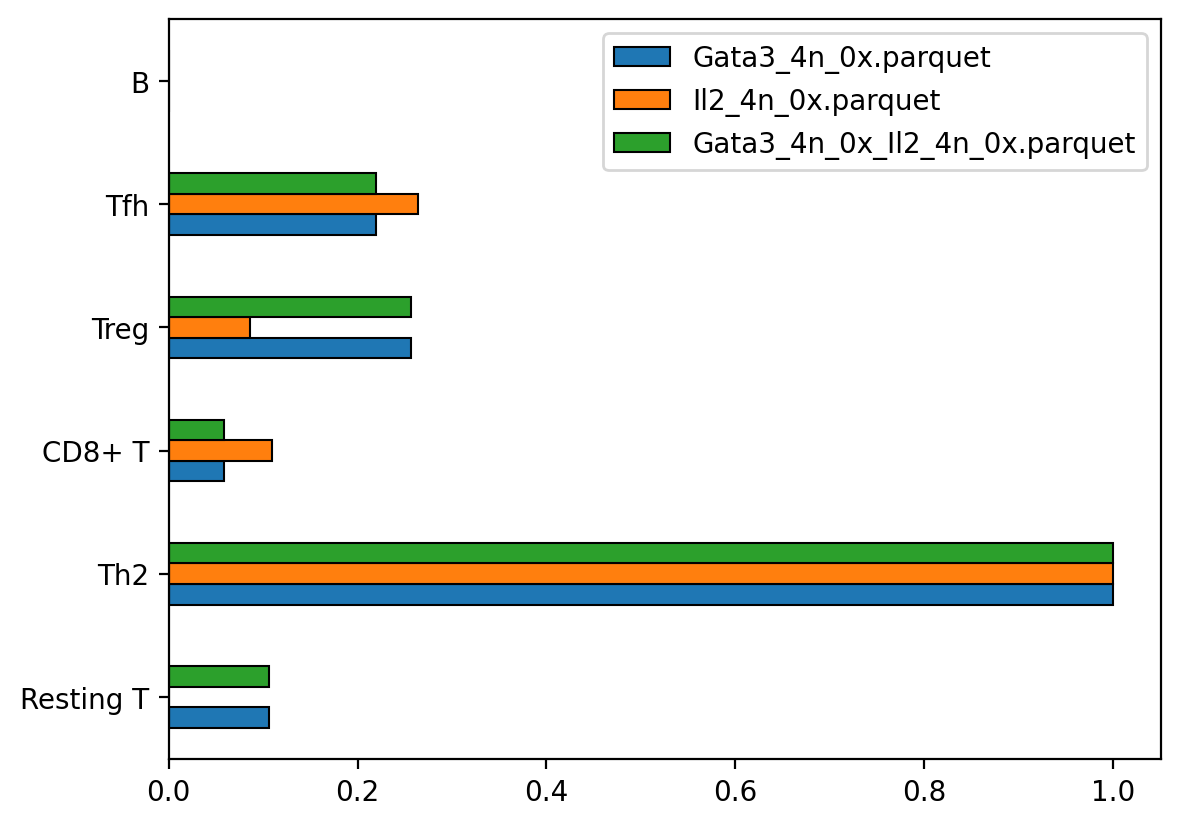

In [80]:
pd.DataFrame(
    MinMaxScaler().fit_transform(pd.concat(ko_data, axis=1)), 
    index=pd.concat(ko_data, axis=1).index, 
    columns=pd.concat(ko_data, axis=1).columns
).plot(kind='barh', legend=True, linewidth=0.75, edgecolor='black')

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [26]:
ko_concat_norm = pd.DataFrame(
    StandardScaler().fit_transform(ko_concat), 
    index=ko_concat.index, 
    columns=ko_concat.columns
)

In [56]:
ko_concat_norm[['Ccr2', 'Ccr4', 'Nampt', 'Lgals9', 'Cd44']]

Ccr2      Ccr4     Nampt    Lgals9      Cd44
cell_type                                                  
Th2       -0.680361  1.070982 -1.021533  1.352570  1.189777
CD8+ T     0.614339  0.036599 -0.420223  0.087565  0.340334
Tfh       -1.019002  0.554135  0.419430  0.413048 -0.157333
Treg       1.930406  0.215755  0.251681  0.226252  0.537643
Resting T -0.285707  0.230793 -1.071330 -0.096568  0.124125
B         -0.559675 -2.108264  1.841975 -1.982867 -2.034547

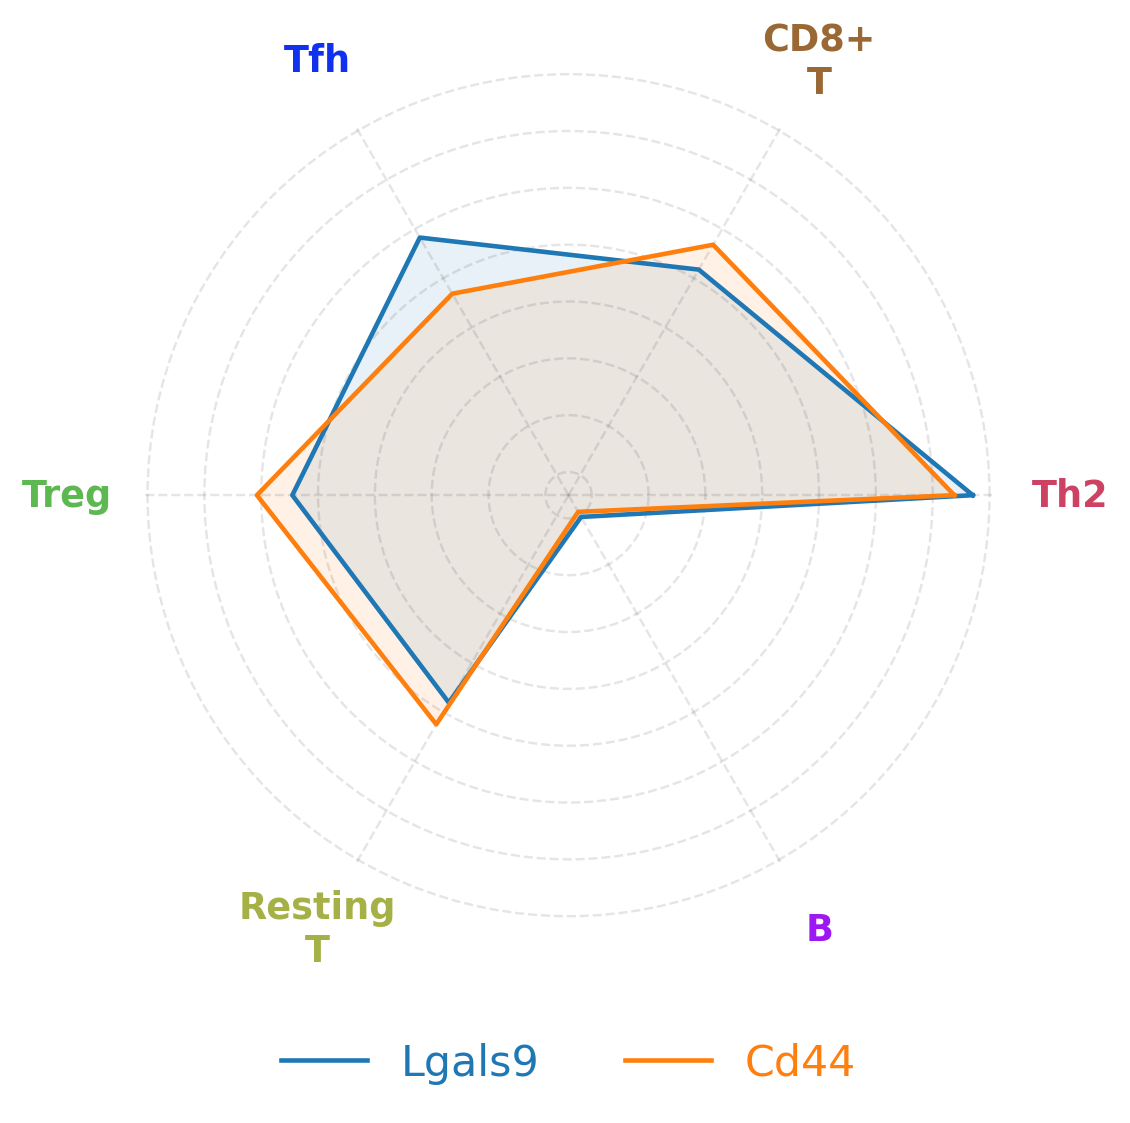

In [98]:
import random

fig, ax = plt.subplots(1, 1, 
        figsize=(5, 5), dpi=110, 
        subplot_kw={'projection': 'polar'})

for i, col in enumerate(['Lgals9', 'Cd44']):
    values = ko_concat_norm[col].values.tolist()
    values += values[:1]  # Repeat first value to close polygon
    
    angles = np.linspace(0, 2*np.pi, len(ko_concat_norm.index), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Repeat first angle to close polygon

    ax.plot(angles, values, '-', linewidth=1.5, 
            label=col, 
            # color=colors[i]
        )
    ax.fill(angles, values, alpha=0.1, 
        edgecolor='black', 
        # color=colors[i], 
        linewidth=0.5, hatch='')
    

ax.set_xticks(angles[:-1])
ax.set_xticklabels(
    ko_concat_norm.index.str.replace(' ', '\n'), size=12,
    fontweight='bold',
)

for t in ax.get_xticklabels():
    txt = t.get_text()
    t.set_color(color_dict[txt.replace('\n', ' ')])
    t.set_fontweight('bold')
ax.set_rlabel_position(0)
ax.tick_params(pad=15)

ax.grid(True, alpha=0.1, linestyle='--', color='black')
ax.set_yticklabels(labels=ax.get_yticks(), size=5)
# print(ax.get_yticks())
# ax.set_yticklabels([])

ax.spines['polar'].set_visible(False)
legend = ax.legend(bbox_to_anchor=(0.5, -0.1), 
    loc='upper center', ncol=3, frameon=False, fontsize=14)
for text, line in zip(legend.get_texts(), legend.get_lines()):
    text.set_color(line.get_color())
ax.set_rlabel_position(35)
ax.set_yticklabels([])
# ax.set_rorigin(0)
# ax.set_yticklabels([None, None, 'low', None, 'medium', None, 'high', None], size=10, 
# color='orange')

# cmap = plt.cm.Reds
# yticks = ax.get_yticks()
# ymin, ymax = min(yticks), max(yticks)
# for t in ax.get_yticklabels():
#     txt = t.get_text()
#     if txt is not None:
#         pos = ax.get_yticks()[ax.get_yticklabels().index(t)]
#         norm_pos = (pos - ymin) / (ymax - ymin)
#         t.set_color(cmap(norm_pos))
#         if txt == 'low':
#             t.set_fontsize(10)
#             t.set_fontweight('light')
#         elif txt == 'medium':
#             t.set_fontsize(15)
#             t.set_fontweight('light')
#         elif txt == 'high':
#             t.set_fontsize(20)
#             t.set_fontweight('light')

# ax.set_title('TF KOs', fontsize=14, fontweight='bold', pad=50)
plt.show()

In [103]:
xy = xy_from_adata(adata)

In [155]:
lr_int =(adata.uns['received_ligands']['Lgals9'] * adata.to_df(
    layer='imputed_count')['Cd44']).to_frame()
lr_int.columns = ['Lgals9_Cd44']
lr_int

Lgals9_Cd44
AAAAAAAAAAAATC  2.973624e-07
AAAAAAAACCAACA  3.438409e-06
AAAAAAAGCCAACA  1.239281e-06
AAAAAAATTTAGGG  3.320458e-06
AAAAAACGGTAGAT  6.488336e-06
...                      ...
TTTTTTGTTTTCTA  7.481873e-06
TTTTTTTATGGTAC  6.355152e-06
TTTTTTTGTCGCCT  1.213364e-06
TTTTTTTTGCTTTA           NaN
TTTTTTTTTAGCTC  3.957464e-06

[24617 rows x 1 columns]

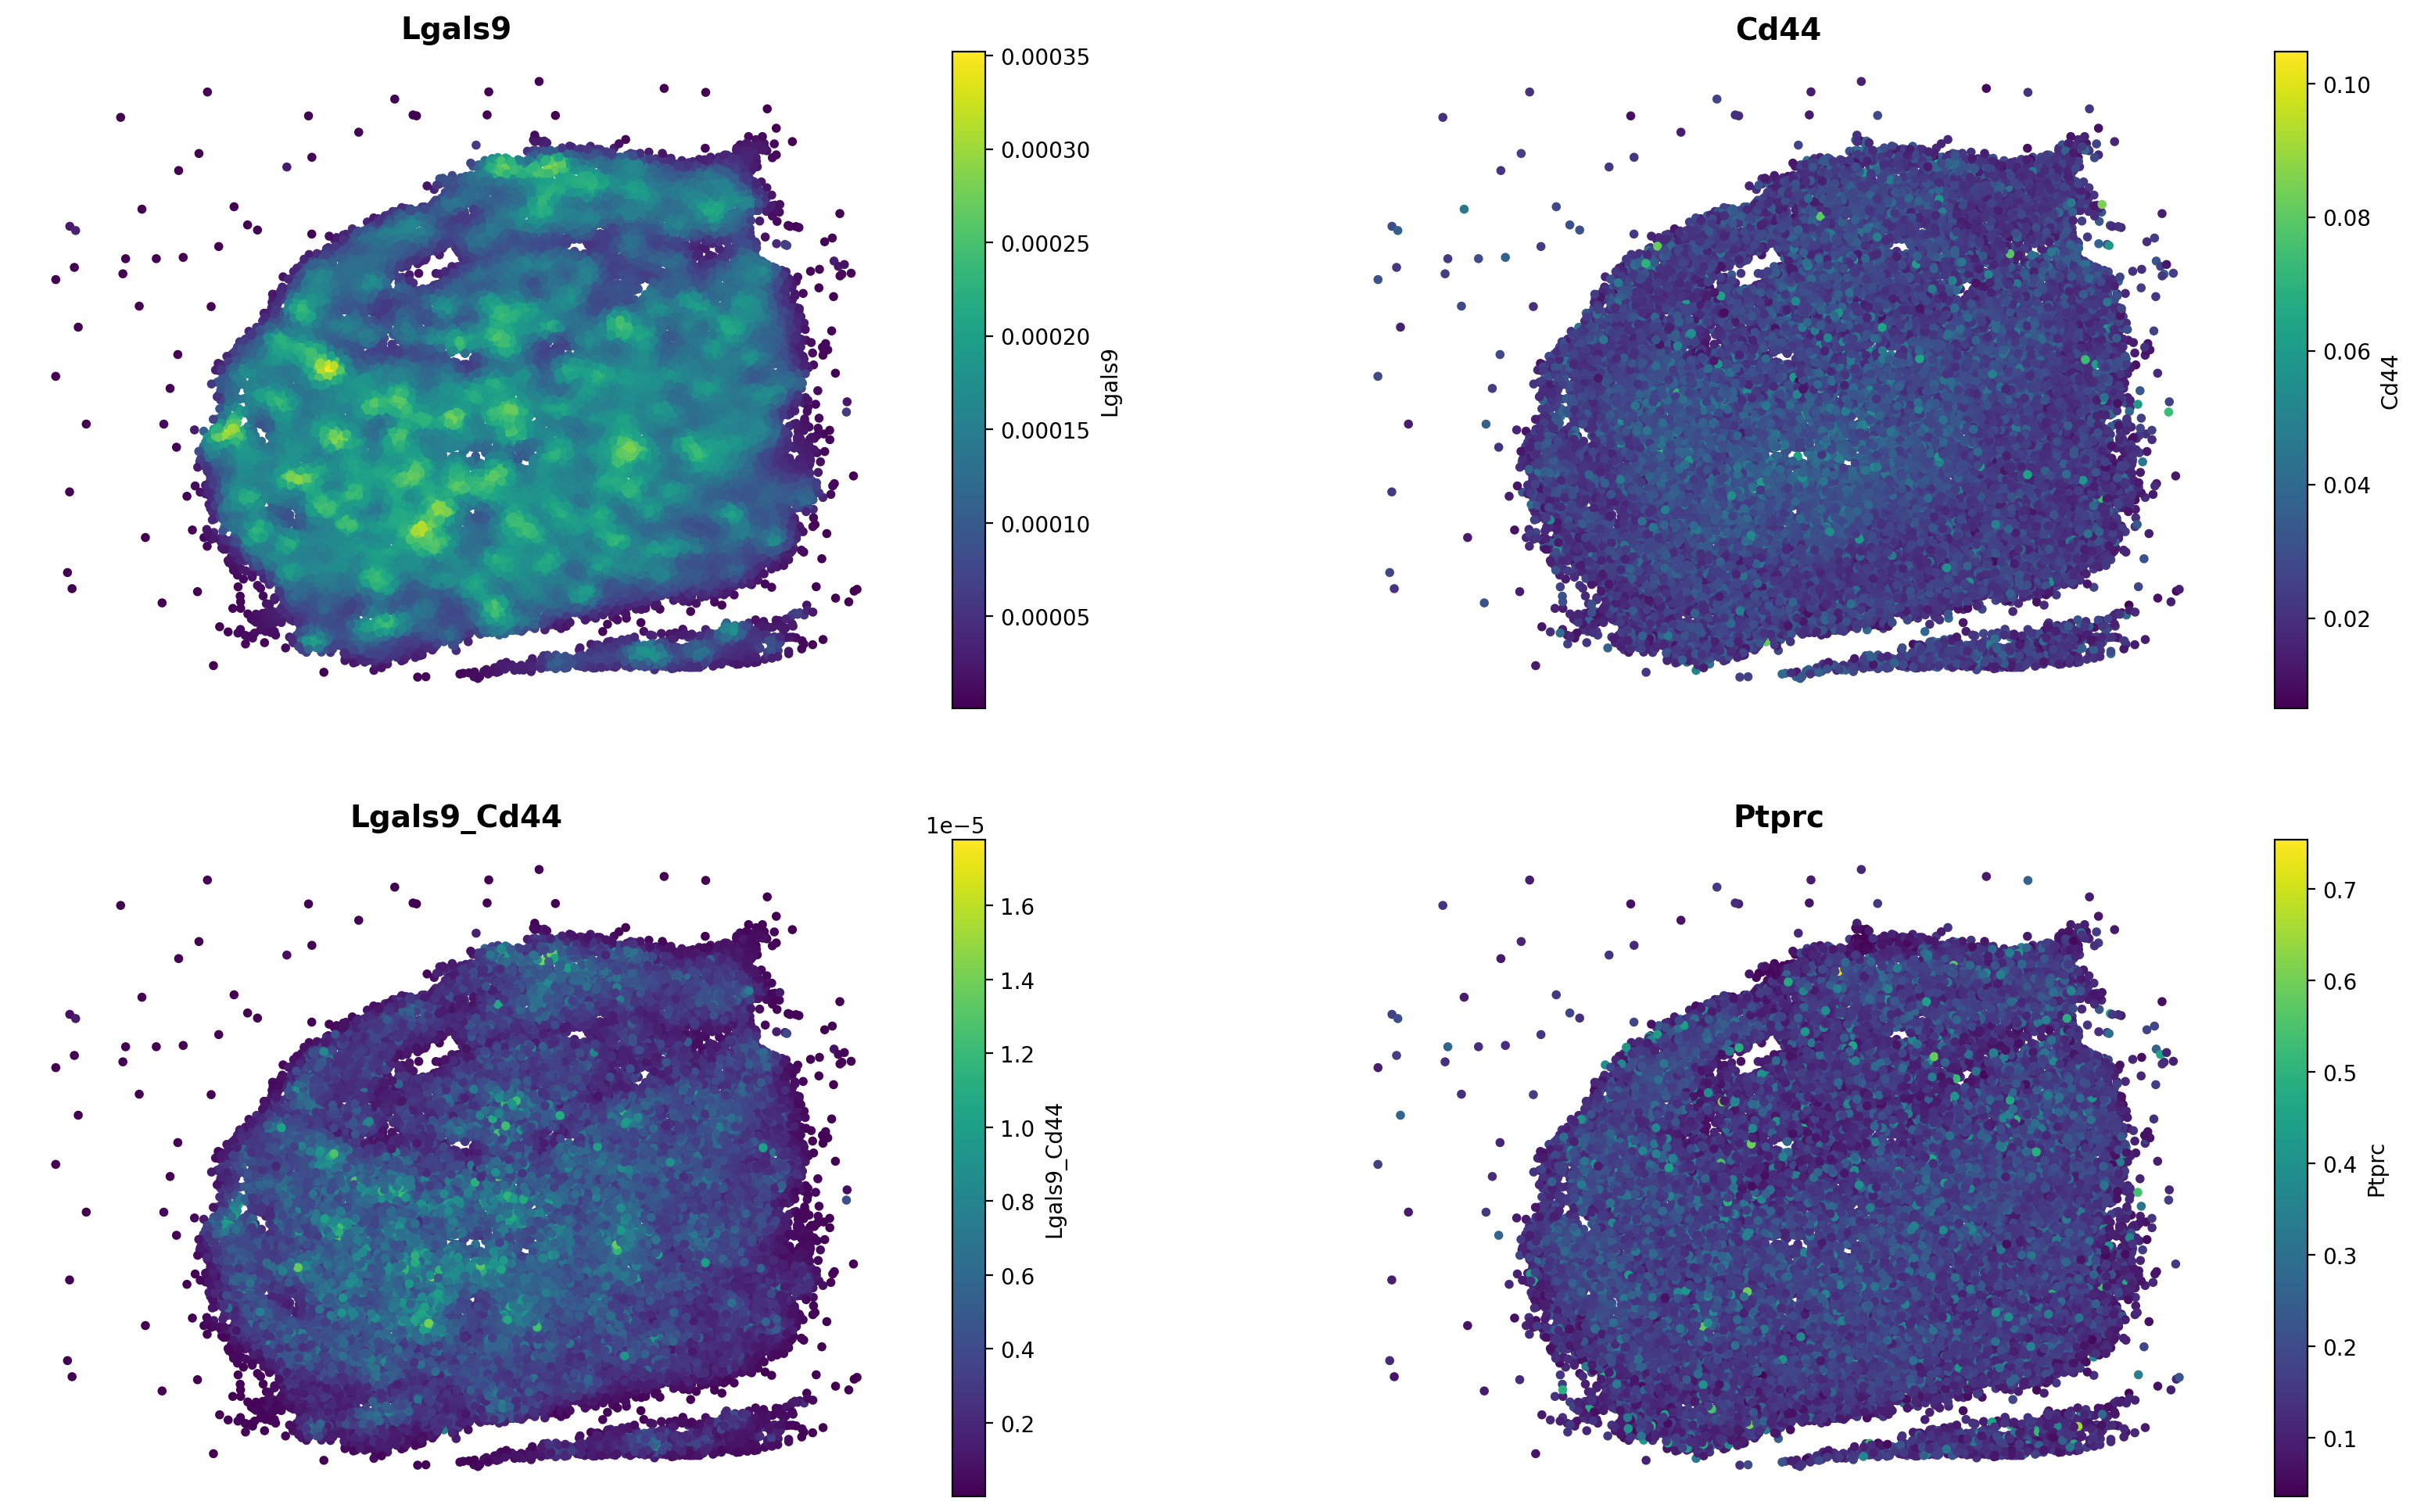

In [174]:
f, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()
data = lr_int.join(
        adata.uns['received_ligands'][['Lgals9']]
    ).join(
        adata.to_df(layer='imputed_count')[['Cd44', 'Ptprc']]
    ).join(xy).dropna()
        
for i, kotarget in enumerate(['Lgals9', 'Cd44', 'Lgals9_Cd44', 'Ptprc']):
    scatter = axs[i].scatter(
        data=data,
        x='x',
        y='y',
        c=kotarget,
        s=10,
        cmap='viridis'
    )
    axs[i].set_title(kotarget, fontsize=14, fontweight='bold')
    plt.colorbar(scatter, ax=axs[i], label=kotarget)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

In [188]:
# cell_counts = adata.obs.celltype_label_tangram.str.split(r'\s\|\s').explode().value_counts()
# plt.figure(figsize=(10, 6))
# ax = sns.barplot(x=cell_counts.index, y=cell_counts.values, 
#         palette=color_dict, linewidth=1, edgecolor='black')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# for i, v in enumerate(cell_counts.values):
#     ax.text(i, v, str(v), ha='center', va='bottom')
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Cell Type', fontsize=12)
# plt.ylabel('Count', fontsize=12)
# plt.tight_layout()
# plt.show()

In [176]:
ref = sc.read_h5ad('/Users/koush/Downloads/zhongli_ref_202401203_mannually_woDoublet.h5ad')
# sc.pp.normalize_total(ref)
# sc.pp.log1p(ref)

In [370]:
ref.X.max()

6.591399991211464

In [371]:
ref.layers['normalized_count'] = ref.X.copy()

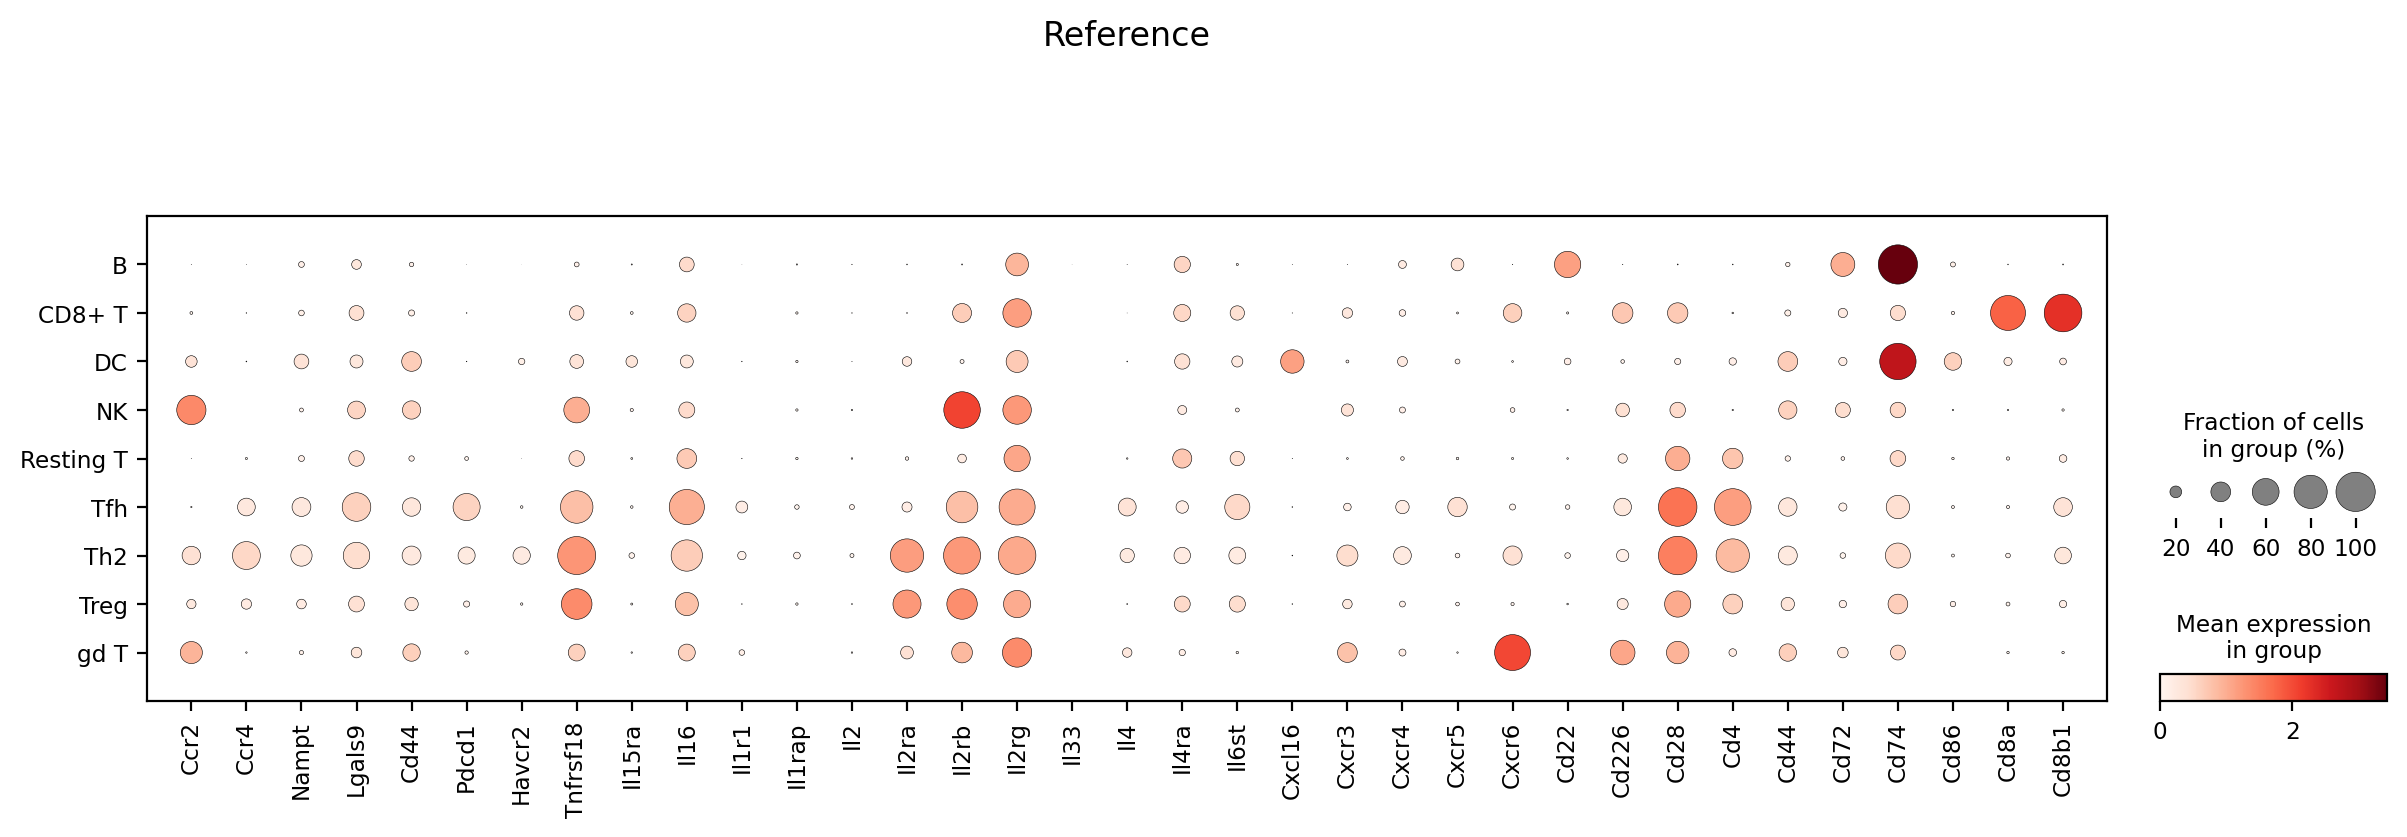

In [381]:
sc.pl.dotplot(
    ref, 
    var_names=[
        'Ccr2', 'Ccr4', 'Nampt','Lgals9', 'Cd44', 'Pdcd1', 'Havcr2', 'Tnfrsf18',
 'Il15ra',
 'Il16',
 'Il1r1',
 'Il1rap',
 'Il2',
 'Il2ra',
 'Il2rb',
 'Il2rg',
 'Il33',
 'Il4',
 'Il4ra',
 'Il6st',
 'Cxcl16',
 'Cxcr3',
 'Cxcr4',
 'Cxcr5',
 'Cxcr6',
 'Cd22',
 'Cd226',
 'Cd28',
 'Cd4',
 'Cd44',
 'Cd72',
 'Cd74',
 'Cd86',
 'Cd8a',
 'Cd8b1'],
    groupby='cell_type',
    layer='normalized_count',
    title='Reference',
)

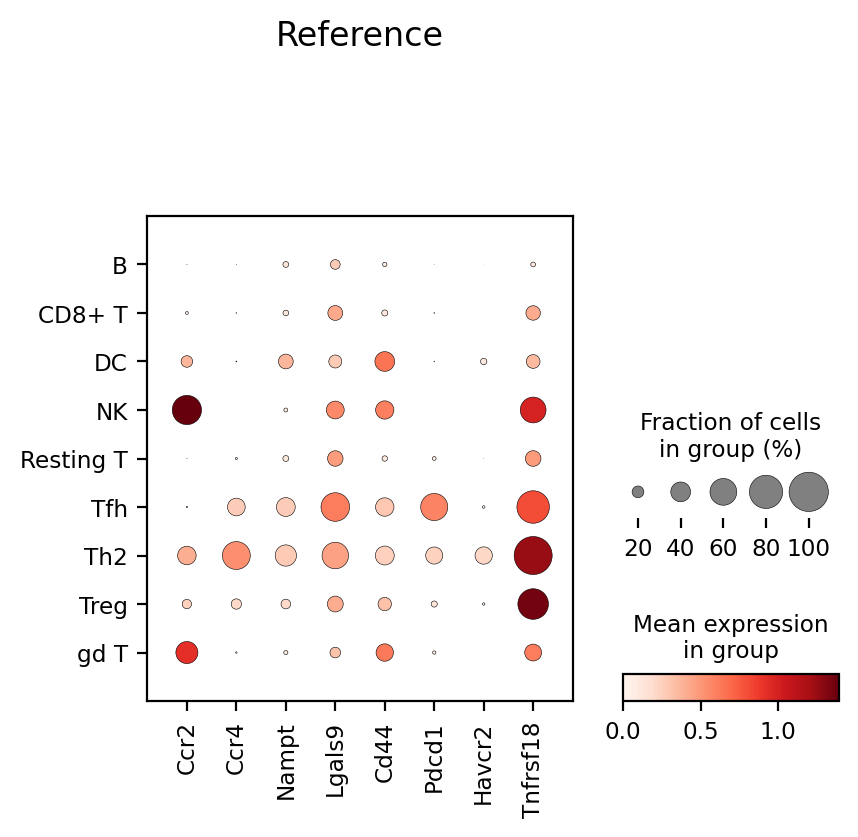

In [372]:
sc.pl.dotplot(
    ref, 
    var_names=['Ccr2', 'Ccr4', 'Nampt','Lgals9', 'Cd44', 'Pdcd1', 'Havcr2', 'Tnfrsf18'],
    groupby='cell_type',
    layer='normalized_count',
    title='Reference',
)

In [395]:
chart = Cartography(adata_m[~adata_m.obs.cell_type.isin(['B', 'Resting T'])], color_dict)
# chart.adata.obs.cell_type = chart.adata.obs.cell_type.cat.remove_unused_categories()
chart.adata.obs.dropna(subset=['x', 'y'], inplace=True)

In [396]:
chart.adata.obs.cell_type.value_counts()

cell_type
CD8+ T    5835
Tfh       1626
Treg      1172
Th2        141
Name: count, dtype: int64

In [397]:
kotarget = 'Lgals9'
ax = chart.plot_umap_quiver(
    perturb_target=kotarget,
    grid_scale=4,
    vector_scale=0.5,
    figsize=(5, 5), 
    hue='cell_type',
    alpha=0.9,
    scatter_size=2,
    betadata_path='/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode',
    legend_on_loc=False,
    rescale=1e12
)
plt.title(f'{kotarget} KO')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

AssertionError: 

In [124]:
import enlighten

In [125]:
# manager = enlighten.get_manager()
# paths = list(glob.glob('/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode/*.parquet'))

# pbar = manager.counter(
#     total=len(paths), 
#     auto_refresh=True,
#     color='salmon'
# )

# ko_screen = []
# for kodf in paths:
#     data = (pd.read_parquet(kodf).loc[adata_m.obs_names] - adata.to_df(
#         layer='imputed_count').loc[adata_m.obs_names]).join(
#         adata_m.obs.cell_type
#     ).groupby(
#         'cell_type'
#     ).mean().abs().mean(axis=1).sort_values(
#         ascending=True
#     )
#     data = data.to_frame()
#     data.columns = [kodf.split('/')[-1].split('_')[0]]
#     ko_screen.append(data)
#     pbar.update()

In [467]:
# pd.concat(ko_screen, axis=1).to_csv('ko_screen.csv')

In [469]:
adata

AnnData object with n_obs × n_vars = 23301 × 3604
    obs: 'cell_type', 'cell_type_int', 'x', 'y'
    uns: 'cell_thresholds', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [126]:
# import matplotlib.pyplot as plt
# import random

# unique_cell_types = adata_m.obs.cell_type.unique()
# fig, axs = plt.subplots(2, 3, figsize=(20, 15))
# for i, cell_type in enumerate(unique_cell_types):
#     row, col = divmod(i, 3)
#     colors = [random.choice(['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(6)]) for _ in range(20)]
#     axs[row, col].barh(pd.concat(ko_screen, axis=1).loc[cell_type].sort_values(ascending=False).head(20).index, 
#                        pd.concat(ko_screen, axis=1).loc[cell_type].sort_values(ascending=False).head(20).values, 
#                        color=colors, linewidth=1, edgecolor='black')
#     axs[row, col].set_title(cell_type)
#     axs[row, col].invert_yaxis()
#     axs[row, col].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.tight_layout()
# plt.show()

In [88]:
import commot as ct

df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='mouse', 
        signaling_type=None
    )
    
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  

In [40]:
df_ligrec[df_ligrec.receptor == 'Ccr4']

ligand receptor pathway           signaling
645  Ccl17     Ccr4     CCL  Secreted Signaling
646  Ccl22     Ccr4     CCL  Secreted Signaling
647   Ccl5     Ccr4     CCL  Secreted Signaling

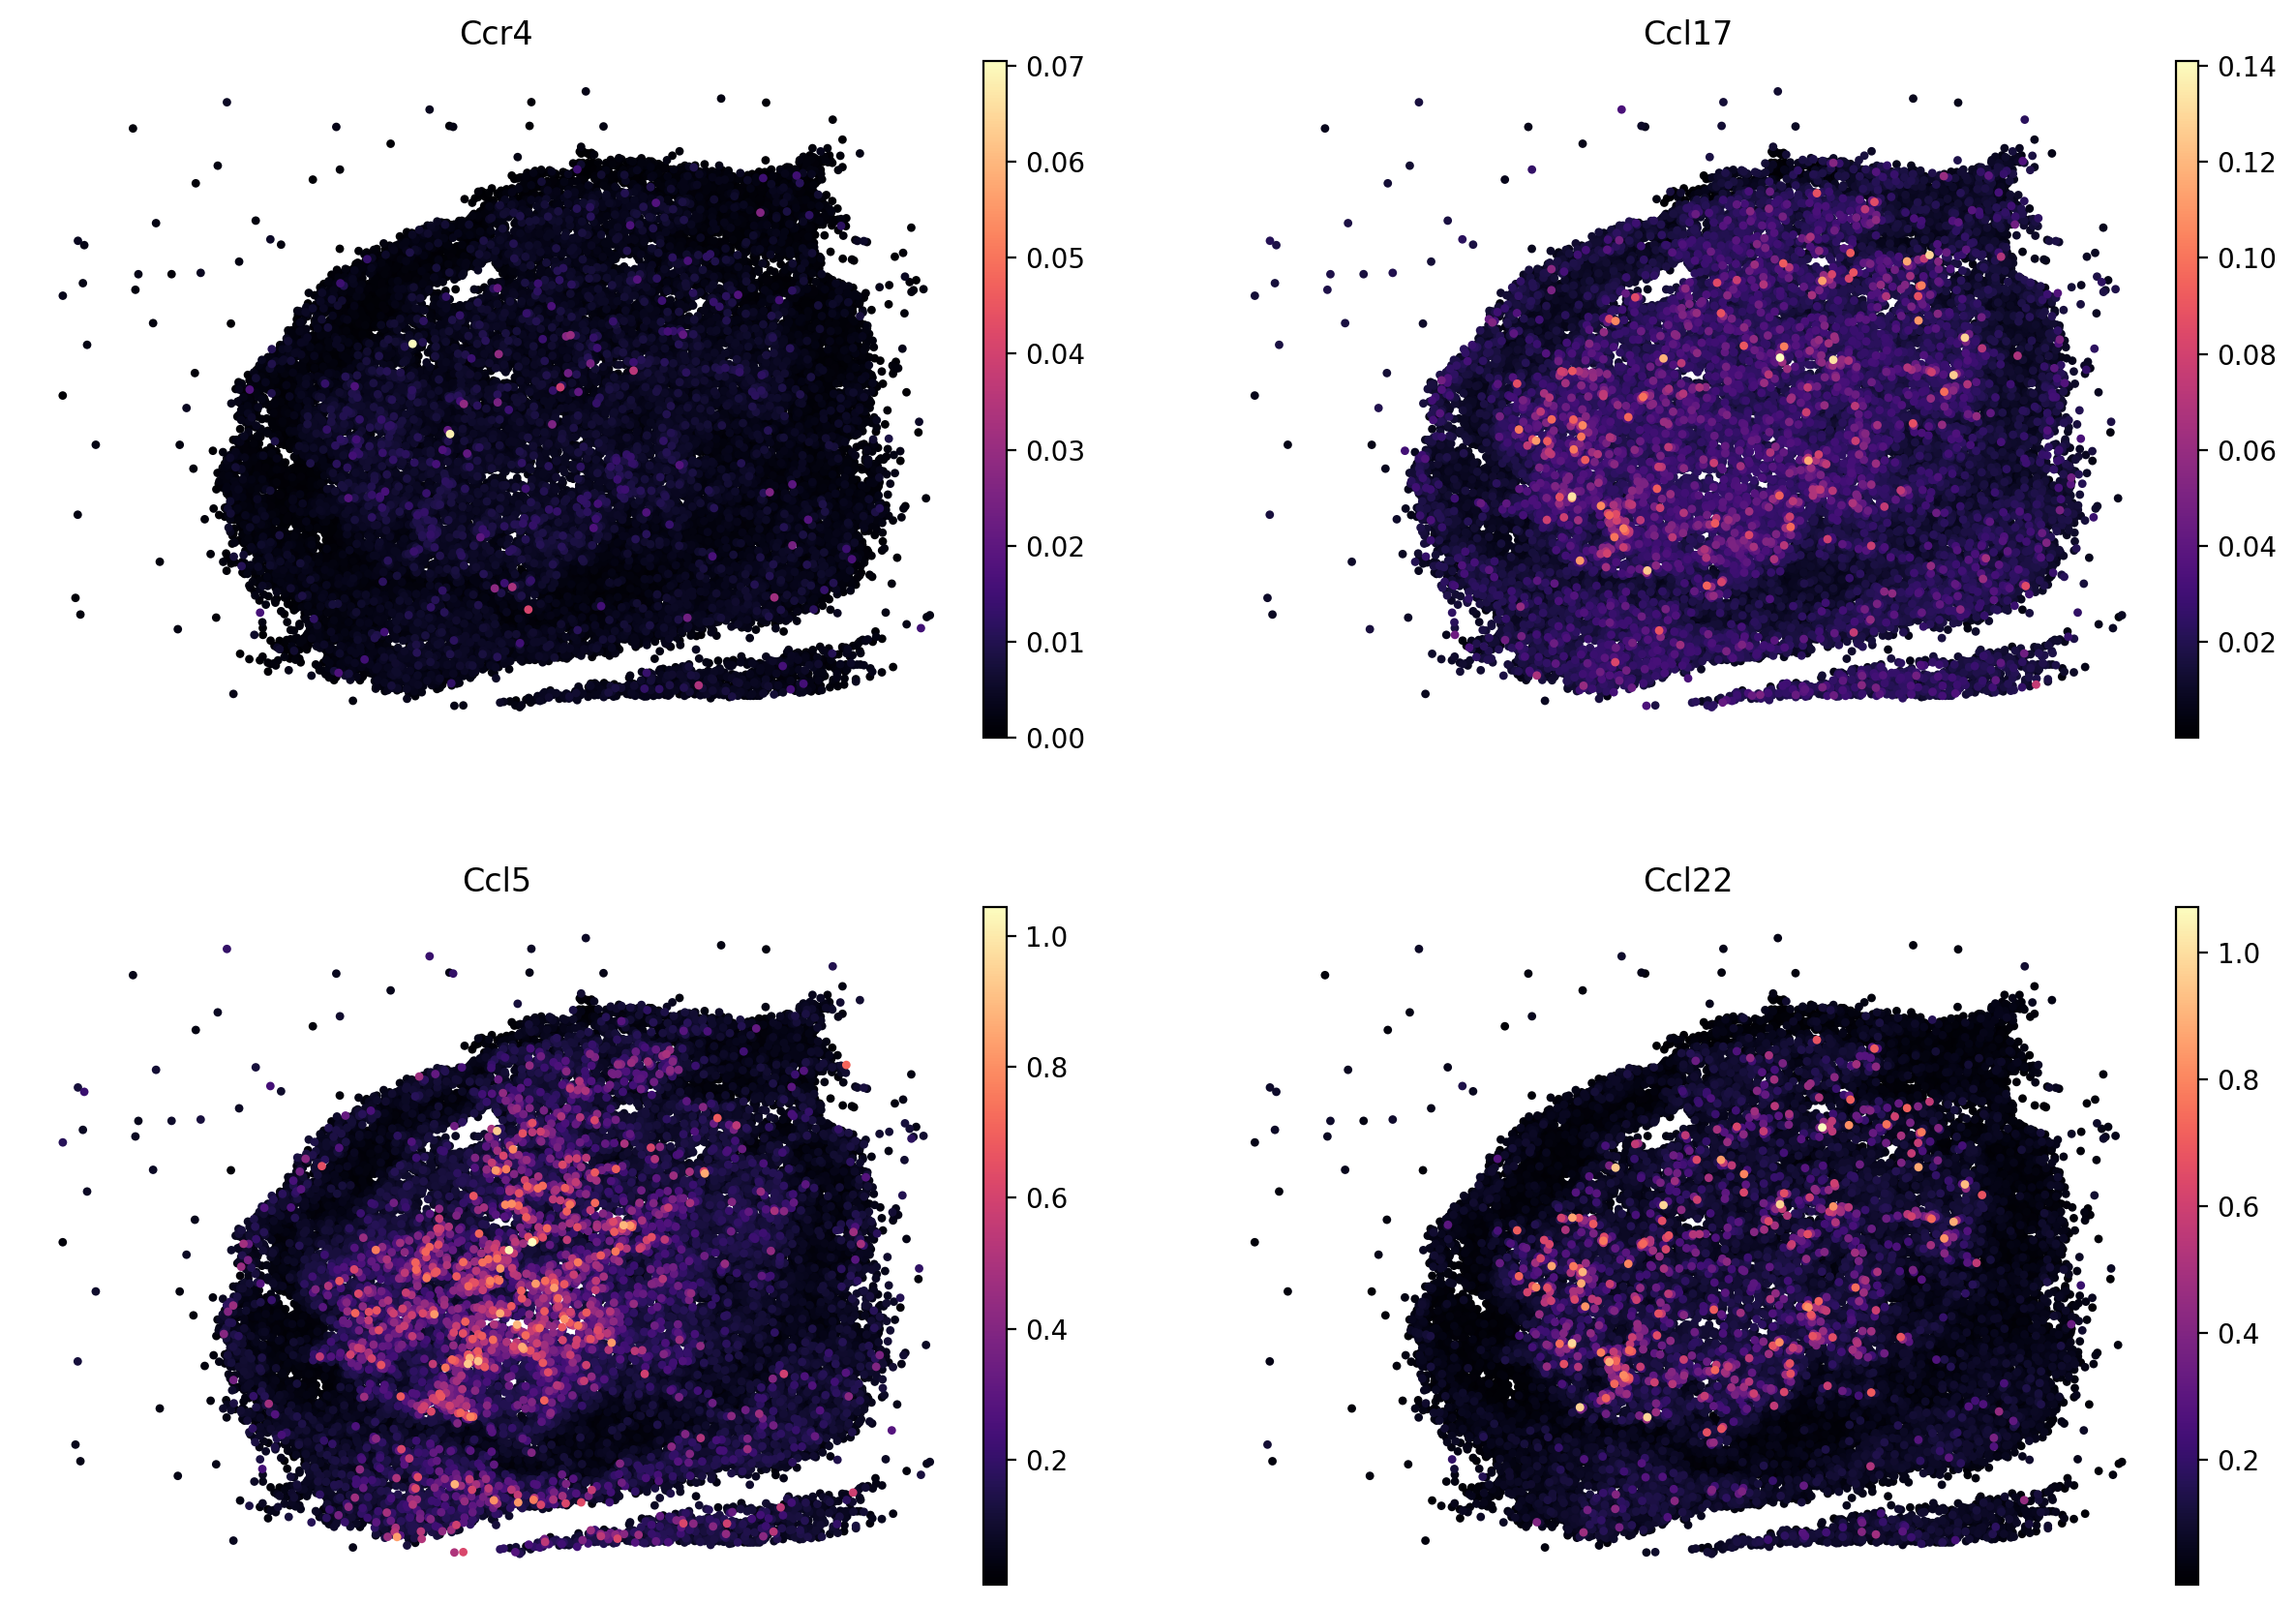

In [83]:
sc.pl.embedding(adata, color=['Ccr4', 'Ccl17', 'Ccl5', 'Ccl22'], add_outline=False, 
    basis='spatial', layer='imputed_count', cmap='magma', frameon=False, size=40, ncols=2)

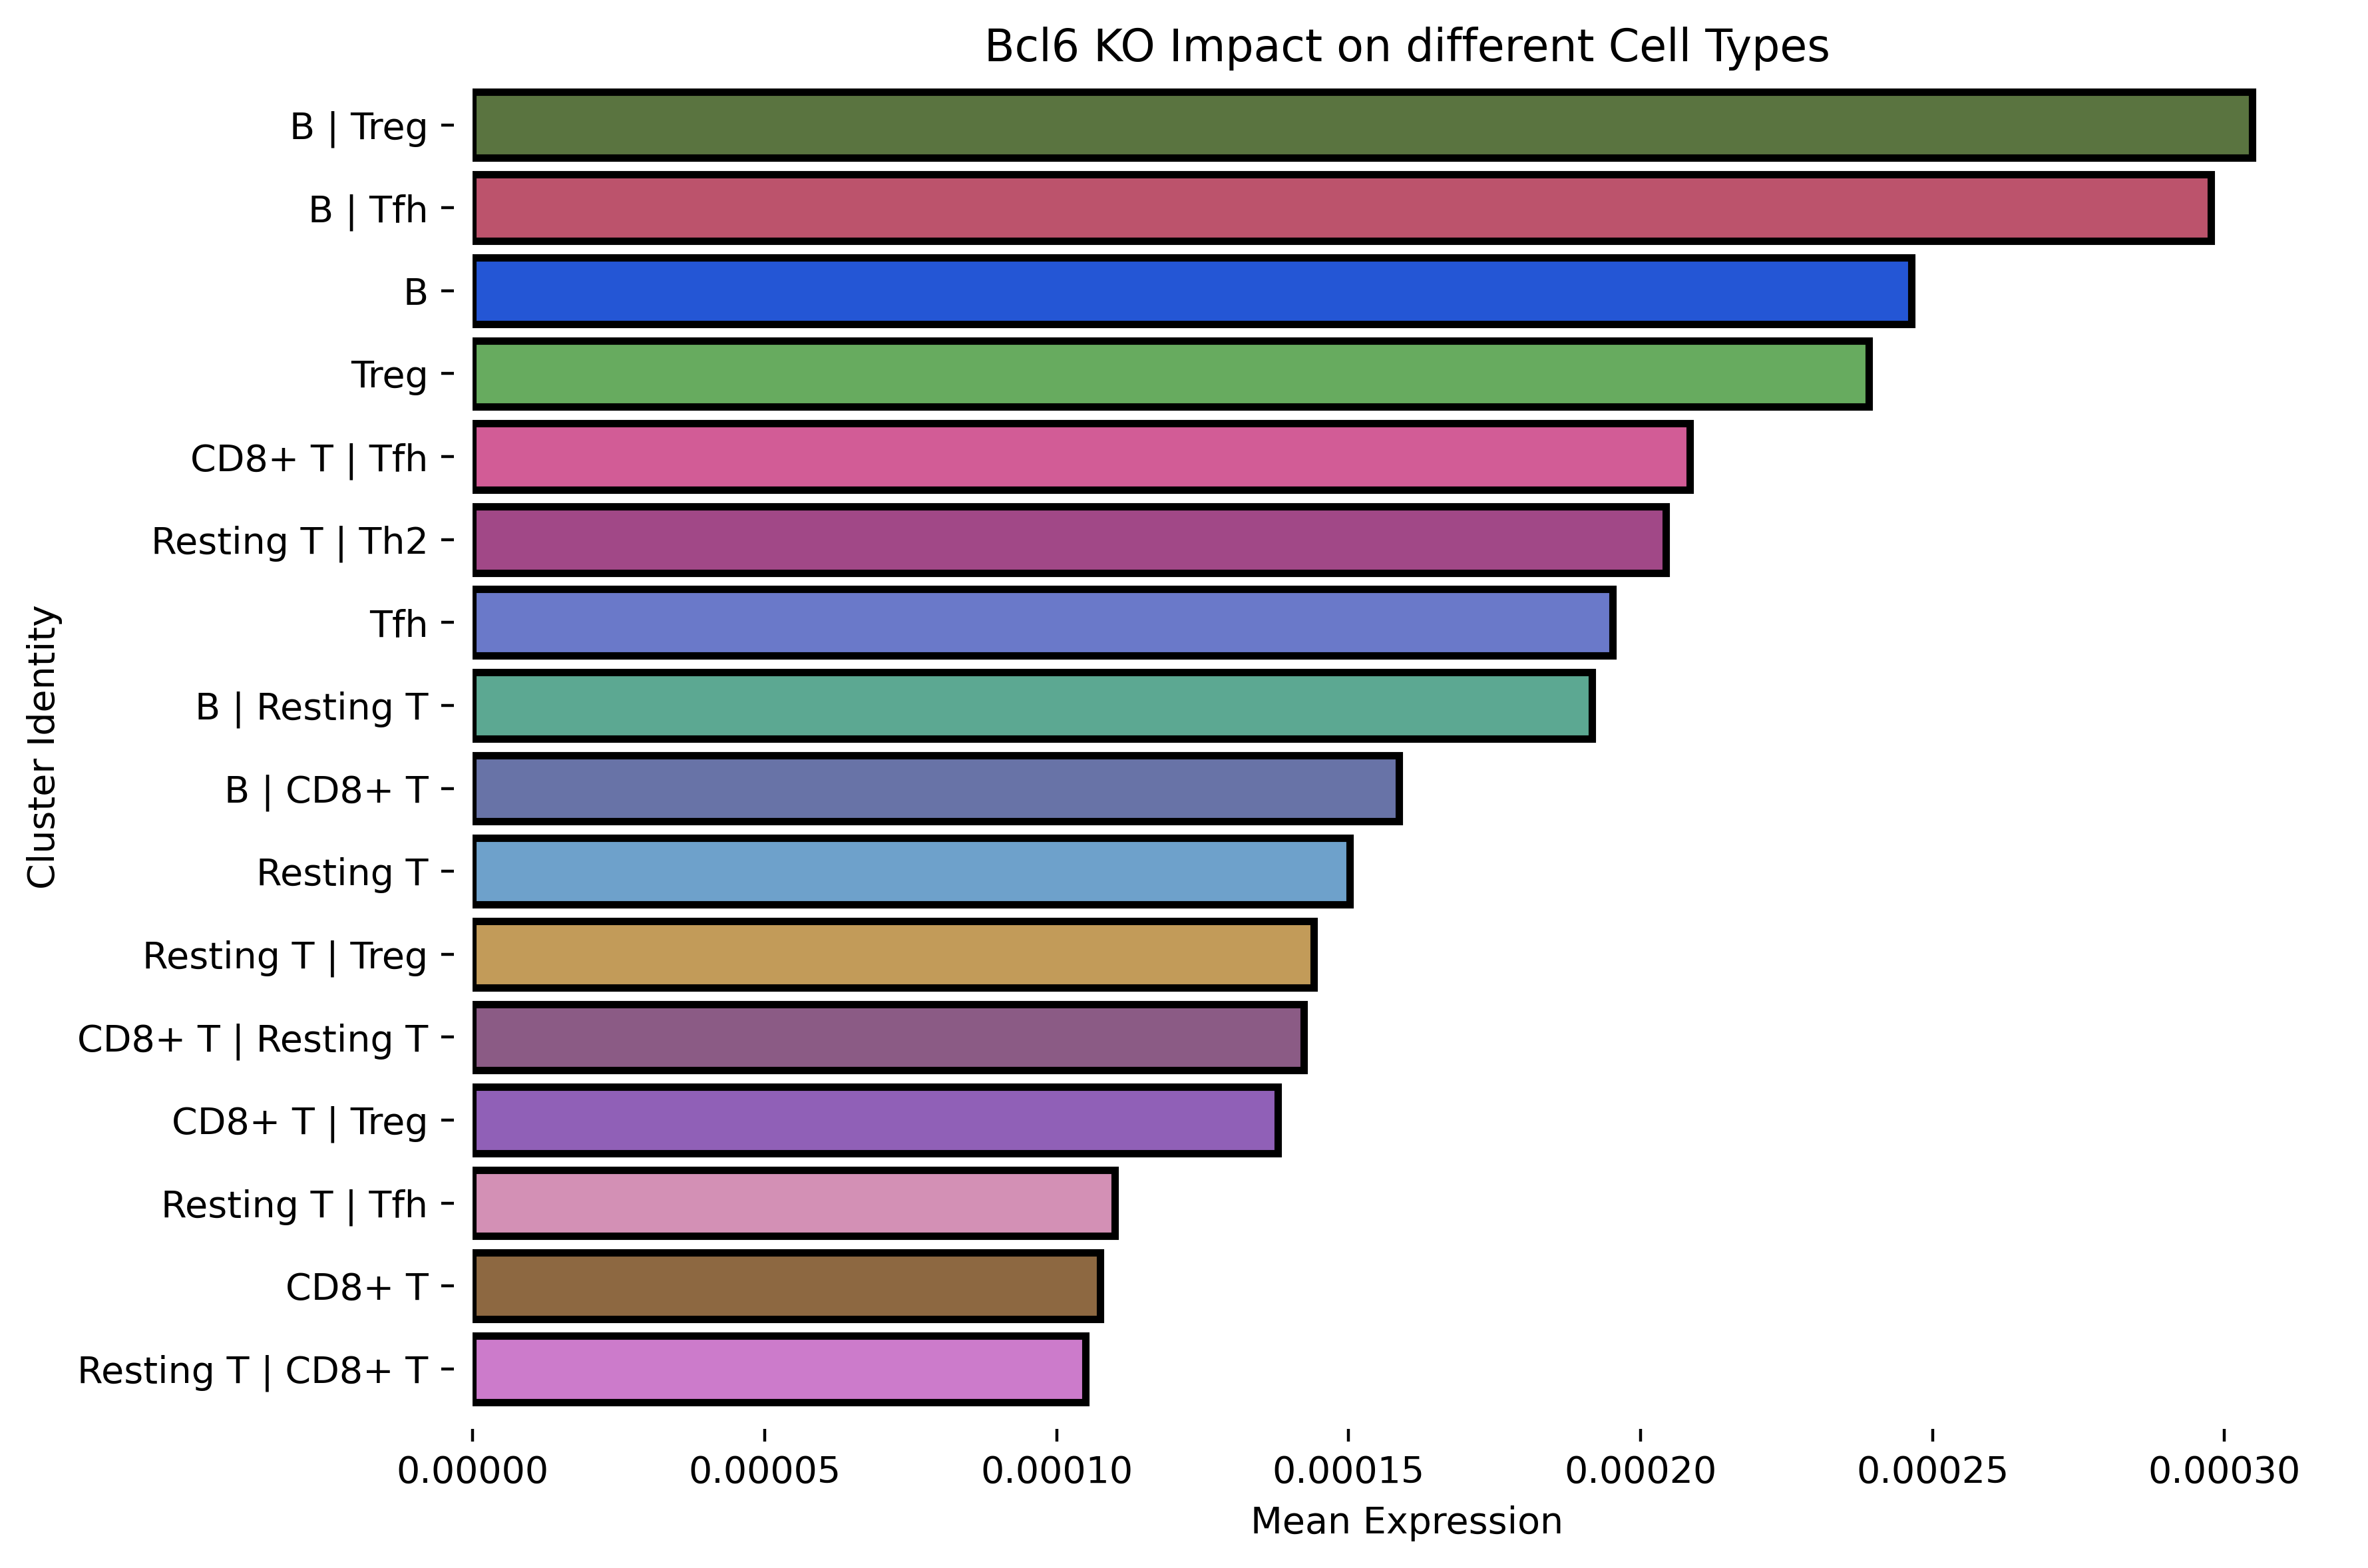

In [118]:
kotarget = 'Bcl6'
data = (pd.read_parquet(
    f'/Volumes/SSD/genome_screens/lymph/{kotarget}_4n_0x.parquet').loc[
        chart.adata.obs_names
    ]-chart.adata.to_df(layer='imputed_count')
    ).join(chart.adata.obs.cell_type).groupby(
        'cell_type'
    ).mean().abs().mean(axis=1).sort_values(
        ascending=True
    )

plt.figure(figsize=(9, 6), dpi=200)
sns.barplot(
    x=data.values,
    y=data.index,
    edgecolor='black',
    palette=color_dict,
    linewidth=2,
    order=data.index[::-1],
)

plt.xlabel('Mean Expression')
plt.ylabel('Cluster Identity')
plt.title(f'{kotarget} KO Impact on different Cell Types')

sns.despine(offset=5)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [1]:
# import random
# colors = [random.choice(['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(6)]) for _ in range(20)]

# ligands = ['Il2', 'Il16',  'Il6st', 'Cxcl13', 'Ccl12', 'Ccl20']
# receptors = ['Il2ra', 'Cxcr4', 'Ccr4', 'Il4ra', 'Ccr4', 'Cxcr5']
# tf = ['Gata3', 'Prdm1', 'Pax5', 'Stat4', 'Foxp3', 'Bcl6']

# fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=200, subplot_kw={'projection': 'polar'})

# # Helper function to plot radar chart
# def plot_radar(kotargets, ax, title):
#     for kotarget in kotargets:
#         data = (pd.read_parquet(
#             f'/tmp/lymph/{kotarget}_4n_0x.parquet').loc[
#                 chart.adata.obs_names
#             ]-chart.adata.to_df(layer='imputed_count')
#             ).join(chart.adata.obs.cell_type).groupby(
#                 'cell_type'
#             ).mean().abs().mean(axis=1)
        
#         # Normalize values between 0 and 1
#         data = (data - data.min()) / (data.max() - data.min())

#         # Prepare data for radar plot
#         categories = data.index.tolist()
#         values = data.values.tolist()
#         values += values[:1] # Repeat first value to close the polygon
#         angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
#         angles = np.concatenate((angles, [angles[0]])) # Repeat first angle to close the polygon

#         # Plot data
#         ax.plot(angles, values, '-', linewidth=0.5, label=kotarget)
#         ax.fill(angles, values, alpha=0.7)
    
#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(categories, size=8)
#     ax.tick_params(pad=20)
#     ax.set_yticklabels([])
#     ax.grid(True, alpha=0.35)
#     ax.spines['polar'].set_visible(False)
#     ax.set_title(title)
#     legend = ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2, markerscale=1)
#     for text, line in zip(legend.get_texts(), legend.get_lines()):
#         text.set_color(line.get_color())

# plot_radar(ligands, axs[0], 'Ligand KO Impacts')
# plot_radar(receptors, axs[1], 'Receptor KO Impacts')
# plot_radar(tf, axs[2], 'Transcription Factor KO Impacts')

# plt.tight_layout()
# plt.show()

In [ ]:
kotarget = 'Ccr4'
data = (pd.read_parquet(
    f'/Volumes/SSD/genome_screens/lymph/{kotarget}_4n_0x.parquet').loc[
        chart.adata.obs_names
    ]-chart.adata.to_df(layer='imputed_count')
    ).join(chart.adata.obs.cell_type_2).groupby(
        'cell_type_2'
    ).mean().abs().mean(axis=1).sort_values(
        ascending=True
    )

plt.figure(figsize=(6, 4), dpi=100)
sns.barplot(
    x=data.values,
    y=data.index,
    edgecolor='black',
    palette=color_dict,
    linewidth=2,
    order=data.index[::-1],
)

plt.xlabel('Mean Expression')
plt.ylabel('Cell Type')
plt.title(f'{kotarget} KO Impact by Cell Type')

sns.despine(offset=5)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [112]:
from spaceoracle.plotting.shift import estimate_transition_probabilities

embedding = adata.obsm['X_umap']
n_neighbors = 200
betadata_path = '/Volumes/SSD/genome_screens/human_tonsil'
perturbed_df = pd.read_parquet(
    f'{betadata_path}/{kotarget}_4n_0x.parquet')
delta_X = perturbed_df.loc[
    chart.adata.obs_names].values - chart.adata.layers['imputed_count']
chart.adata.layers[kotarget] = perturbed_df.loc[chart.adata.obs_names].values.copy()
corr = chart.get_corr(kotarget)
P = estimate_transition_probabilities(
    adata, delta_X, embedding, n_neighbors=n_neighbors, n_jobs=1)
del chart.adata.layers[kotarget]

In [122]:
chart.adata.obs

cell_type   author_cell_type cell_type_int leiden leiden_R  \
NAME                                                                            
AAACCCAAGCGCCTTG-1   T cells              T_CD4             7      0      0,0   
AAACCCAAGTGGACGT-1    Plasma             plasma             6      4        1   
AAACCCACAGAAGTGC-1      GC B  B_germinal_center             4      5        2   
AAACCCATCATCGCAA-1  B memory           B_memory             0      7        4   
AAACCCATCCGATCGG-1    Plasma  B_germinal_center             6      4        1   
...                      ...                ...           ...    ...      ...   
TTTGTTGCAGGGACTA-1      GC B  B_germinal_center             4      5        2   
TTTGTTGCATTGTAGC-1    Plasma             plasma             6      4        1   
TTTGTTGGTACCACGC-1      GC B  B_germinal_center             4      5        2   
TTTGTTGGTCTGTCCT-1    CD4+ T              T_CD4             2      2      0,2   
TTTGTTGTCATGCGGC-1    CD4+ T              T_CD4             2      2      0,2   

                   cell_type_2      banksy_celltypes  
NAME                                                  
AAACCCAAGCGCCTTG-1    T memory                 T_CD4  
AAACCCAAGTGGACGT-1      Plasma                plasma  
AAACCCACAGAAGTGC-1        GC B         GC Light Zone  
AAACCCATCATCGCAA-1    B memory              B_memory  
AAACCCATCCGATCGG-1      Plasma  GC Intermediate Zone  
...                        ...                   ...  
TTTGTTGCAGGGACTA-1        GC B          GC Dark Zone  
TTTGTTGCATTGTAGC-1      Plasma                plasma  
TTTGTTGGTACCACGC-1        GC B          GC Dark Zone  
TTTGTTGGTCTGTCCT-1      CD4+ T                 T_CD4  
TTTGTTGTCATGCGGC-1      CD4+ T                 T_CD4  

[5139 rows x 7 columns]

In [123]:
# chart.adata.obs = chart.adata.obs.join(pd.read_csv('banksy_celltypes.csv', index_col=0))

In [146]:
chart.adata.obs.loc[chart.adata.obs['cell_type'] == 'GC B', 'cell_type_2'] = chart.adata.obs['banksy_celltypes']

In [150]:
chart.adata.obs.cell_type_2.value_counts()

cell_type_2
GC B        1581
B memory     873
B naive      715
CD4+ T       530
Plasma       490
Tfh          404
T memory     371
CD8+ T       175
Name: count, dtype: int64

In [138]:
chart.adata.obs[chart.adata.obs.cell_type=='GC B'].cell_type_2 = None

In [140]:
chart.adata.obs[chart.adata.obs.cell_type=='GC B'].cell_type_2

NAME
AAACCCACAGAAGTGC-1    GC B
AAACGAATCCGTCCTA-1    GC B
AAACGAATCTTTGGAG-1    GC B
AAACGCTCAGCTGAAG-1    GC B
AAACGCTCAGTGTACT-1    GC B
                      ... 
TTTGGAGGTGTACGCC-1    GC B
TTTGGAGGTTAACCTG-1    GC B
TTTGGTTCATGTGACT-1    GC B
TTTGTTGCAGGGACTA-1    GC B
TTTGTTGGTACCACGC-1    GC B
Name: cell_type_2, Length: 1581, dtype: category
Categories (8, object): ['B memory', 'B naive', 'CD4+ T', 'CD8+ T', 'GC B', 'Plasma', 'T memory', 'Tfh']

In [70]:
source_ct = 'B_naive'
transition_df = chart.compute_transitions(corr, source_ct=source_ct)

In [71]:
chart.assess_transitions(
    transition_df, 
    base_celltypes=adata.obs.banksy_celltypes, 
    source_ct=source_ct
)

Source Cells: B_naive           min      mean       max
Transition Target                                      
B_naive                3.420945e-10  0.000699  0.001233
B_memory               2.023134e-10  0.000471  0.001060
pDC                    8.469155e-09  0.000053  0.010310
FDC                    4.030107e-10  0.000033  0.002592
T_CD4                  3.030271e-09  0.000030  0.000899
mDC/myeloid            1.258382e-09  0.000025  0.000575
T_CD8                  2.063119e-09  0.000024  0.003378
T_follicular_helper    2.426093e-10  0.000020  0.001501
GC Dark Zone           1.718281e-12  0.000008  0.000361
GC Light Zone          9.751556e-12  0.000007  0.000797
plasma                 8.685132e-12  0.000006  0.000128
GC Intermediate Zone   5.938835e-13  0.000006  0.000480

In [36]:
thresh = 0.00045 # need to cross this to leave base cell phenotype
allowed_fates = [
    # 'T_CD4',
    'plasma',
    'GC Light Zone',
    'B_memory',
    'GC Intermediate Zone',
    # 'T_follicular_helper',
    'GC Dark Zone',
    # 'FDC',
    'B_naive',
    # 'T_CD8',
    # 'mDC/myeloid',
    # 'pDC'
]

transitions = chart.get_cellfate(transition_df, allowed_fates, thresh)

100%|██████████| 274/274 [00:03<00:00, 84.11it/s]

Counter({'B_memory': 184, 'plasma': 70, 'GC Dark Zone': 17, 'B_naive': 2, 'GC Light Zone': 1}) 0.0004521653387598443


In [37]:
projection_params = {
    'basis': 'spatial',
    'color': 'banksy_celltypes', 
    'legend_loc': 'right',
    'recompute': True,
    'stream': False,
    'scale': 0.8,
    'alpha': 0.6,
    'size': 50,
    'show': False,
    'linewidth': 0.1,
    'palette': color_dict,
    'min_mass': 50,
    'smooth': 1.0,
    'edgecolor': 'none',
    'arrow_color':'black',
    'n_neighbors': 100,
}

In [38]:
%%capture
X_grid, V_grid = chart.get_grids(P, projection_params)
vector_field_df = chart.vector_field_df(X_grid, V_grid)


In [39]:
import alphashape

In [40]:
source_cells = adata.obs[adata.obs['banksy_celltypes'] == source_ct].index

In [41]:
adata.obs['transition'] = adata.obs['banksy_celltypes'].copy()
adata.obs.loc[source_cells, 'transition'] = np.array(transitions)
ct_points_wt, ct_points_ko = chart.make_celltype_dict()

In [42]:
delta_df = adata.to_df(layer='FOXO1') - adata.to_df(layer='imputed_count')


In [44]:
alpha_shape_1 = alphashape.alphashape(ct_points_wt['GC Light Zone'], alpha=0.04)
alpha_shape_2 = alphashape.alphashape(ct_points_wt['GC Dark Zone'], alpha=0.04)
alpha_shape_3 = alphashape.alphashape(ct_points_wt['GC Intermediate Zone'], alpha=0.04)

In [212]:
# fig, ax = plt.subplots(figsize=(10, 10), dpi=120)
# data = xy.join(adata.obs)
# source_data = data[data.banksy_celltypes == source_ct]
# transition_data = data.loc[source_cells]

# scatter = sns.scatterplot(
#     data=xy.join(adata.obs),
#     x='x', y='y',
#     # hue='banksy_celltypes', 
#     color='grey',
#     s=30,
#     alpha=0.3,
#     edgecolor='none',
#     # palette=color_dict,
#     ax=ax,
# )

# alpha_shape_1 = alphashape.alphashape(ct_points_ko['GC Light Zone'], alpha=0.04)
# alpha_shape_2 = alphashape.alphashape(ct_points_ko['GC Dark Zone'], alpha=0.04)
# alpha_shape_3 = alphashape.alphashape(ct_points_ko['GC Intermediate Zone'], alpha=0.04)

# zone_alpha = 0.85
# for geom in alpha_shape_1.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Light Zone'], alpha=zone_alpha)
        

# for geom in alpha_shape_2.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Dark Zone'], alpha=zone_alpha)

# for geom in alpha_shape_3.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Intermediate Zone'], alpha=zone_alpha)

# alpha_shape_4 = alphashape.alphashape(
#     np.concatenate(
#         [ct_points_wt['GC Light Zone'], 
#          ct_points_wt['GC Intermediate Zone'], 
#          ct_points_wt['GC Dark Zone']]
#         ), alpha=0.03)

# for geom in alpha_shape_4.geoms:
#     if geom.area > 10000:
#         ax.plot(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color='black', alpha=zone_alpha)

# ax.set_frame_on(False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_aspect('equal')
# ax.set_xlim(data.x.min() - 10, data.x.max() + 10)
# ax.set_ylim(data.y.min() - 10, data.y.max() + 10)
# plt.show()